In [1]:
# IMPORTS
from __future__ import annotations
import torch    
import pytomography
from pytomography.metadata import ObjectMeta
from pytomography.metadata.PET import PETLMProjMeta
from pytomography.projectors.PET import PETLMSystemMatrix
from pytomography.algorithms import OSEM, MLEM
from pytomography.io.PET import gate, shared
from pytomography.likelihoods import PoissonLogLikelihood
import os
from pytomography.transforms.shared import GaussianFilter
import matplotlib.pyplot as plt
from pytomography.utils import sss

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

torch.cuda.is_available = lambda: False
print(f"CUDA available: {torch.cuda.is_available()}")
pytomography.device = 'cpu'
print(f"Current device: {pytomography.device}")
torch.cuda.empty_cache()

CUDA available: False
Current device: cpu


In [2]:
info = {'min_rsector_difference': 0,
 'crystal_length': 20.0,
 'radius': 337.0,
 'crystalTransNr': 8,
 'crystalTransSpacing': 4.0,
 'crystalAxialNr': 8,
 'crystalAxialSpacing': 4.0,
 'submoduleAxialNr': 1,
 'submoduleAxialSpacing': 0,
 'submoduleTransNr': 1,
 'submoduleTransSpacing': 0,
 'moduleTransNr': 1,
 'moduleTransSpacing': 0.0,
 'moduleAxialNr': 8,
 'moduleAxialSpacing': 32.25,
 'rsectorTransNr': 56,
 'rsectorAxialNr': 1,
 'NrCrystalsPerRing': 448,
 'NrRings': 64,
 'firstCrystalAxis': 1}

In [3]:
voxel_space = (128,128,96)

object_meta = ObjectMeta(
    dr=(2,2,2), #mm
    shape=voxel_space #voxels
)

In [4]:
# Create a 1000x2 tensor with random integers, ensuring pairs are never equal
detector_ids = torch.full((1000, 2), 0, dtype=torch.long)
detector_ids[:, 0] = 3
detector_ids[:, 1] = 6
detector_ids = torch.randint(low=0, high=64*8, size=(1000, 2))


sinogram_delays  = gate.listmode_to_sinogram(detector_ids , info)
sinogram_delays  = gate.smooth_randoms_sinogram(sinogram_delays , info, sigma_r=4, sigma_theta=4, sigma_z=4)
lm_delays = shared.sinogram_to_listmode(detector_ids, sinogram_delays , info)

In [5]:
import numpy as np

# Create a 3D Gaussian attenuation map with max value 1

# Define grid
x = np.linspace(-1, 1, 128)
y = np.linspace(-1, 1, 128)
z = np.linspace(-1, 1, 96)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# 3D Gaussian parameters
sigma_x, sigma_y, sigma_z = 0.3, 0.3, 0.3
gaussian = np.exp(-((X**2)/(2*sigma_x**2) + (Y**2)/(2*sigma_y**2) + (Z**2)/(2*sigma_z**2)))
gaussian = gaussian / gaussian.max()  # Normalize to max 1

atten_map = torch.from_numpy(gaussian.astype(np.float32)).to(pytomography.device)
# atten_map = torch.zeros((128,128,96), dtype=torch.float32).to(pytomography.device)  # Placeholder for attenuation map
# atten_map = gate.get_aligned_attenuation_map(os.path.join(path, 'gate_simulation/simple_phantom/umap_mMR_brainSimplePhantom.hv'), object_meta).to(pytomography.device)


# normalization_weights = torch.ones((411027456,), dtype=torch.float32).to(pytomography.device)
# normalization_weights = torch.load(os.path.join(path, 'normalization_weights.pt'))

proj_meta = PETLMProjMeta(
    detector_ids,
    info,
    # weights_sensitivity=normalization_weights
    )

psf_transform = GaussianFilter(3.)

system_matrix = PETLMSystemMatrix(
       object_meta,
       proj_meta,
       obj2obj_transforms = [psf_transform],
       N_splits=10,
       device=pytomography.device,
       attenuation_map=atten_map.to(pytomography.device),
)

In [6]:
# Get additive term (without scatter term):
lm_sensitivity = system_matrix._compute_sensitivity_projection(all_ids=False)
additive_term = lm_delays / lm_sensitivity
additive_term[additive_term.isnan()] = 0 # remove NaN values
# Recon
likelihood = PoissonLogLikelihood(
        system_matrix,
        additive_term = additive_term
    )

recon_algorithm = OSEM(likelihood)
recon_without_scatter_estimation = recon_algorithm(4,14)

In [ ]:
sinogram_scatter = sss.get_sss_scatter_estimate(
    object_meta = object_meta,
    proj_meta = proj_meta,
    pet_image = recon_without_scatter_estimation,
    attenuation_image = atten_map,
    system_matrix = system_matrix,
    proj_data = None, # assumes listmode
    image_stepsize = 16,
    # image_stepsize = 4,
    attenuation_cutoff = 0.004,
    sinogram_interring_stepsize = 16,
    # sinogram_interring_stepsize = 4,
    sinogram_intraring_stepsize = 16,
    # sinogram_intraring_stepsize = 4,
    sinogram_random = sinogram_delays
    )
# Now convert to listmode
lm_scatter = shared.sinogram_to_listmode(proj_meta.detector_ids, sinogram_scatter, proj_meta.info)

tensor([[ 16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,
          16,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,
          32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,
          32,  32,  32,  32,  48,  48,  48,  48,  48,  48,  48,  48,  48,  48,
          48,  48,  48,  48,  48,  48,  48,  48,  48,  48,  48,  48,  48,  48,
          48,  48,  48,  48,  48,  48,  48,  64,  64,  64,  64,  64,  64,  64,
          64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,
          64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  80,  80,  80,  80,
          80,  80,  80,  80,  80,  80,  80,  80,  80,  80,  80,  80,  80,  80,
          80,  80,  80,  80,  80,  80,  80,  80,  80,  80,  80,  80,  80,  96,
          96,  96,  96,  96,  96,  96,  96,  96,  96,  96,  96,  96,  96,  96,
          96,  96,  96,  96,  96,  96,  96,  96,  96,  96,  96,  96,  96,  96,
          96,  96, 112, 112, 112, 112, 112, 112, 112

In [8]:
additive_term = (lm_scatter + lm_delays) / lm_sensitivity

additive_term[additive_term.isnan()] = 0
likelihood = PoissonLogLikelihood(
        system_matrix,
        additive_term = additive_term
    )
recon_algorithm = OSEM(likelihood)
recon_lm_nontof = recon_algorithm(4,14)

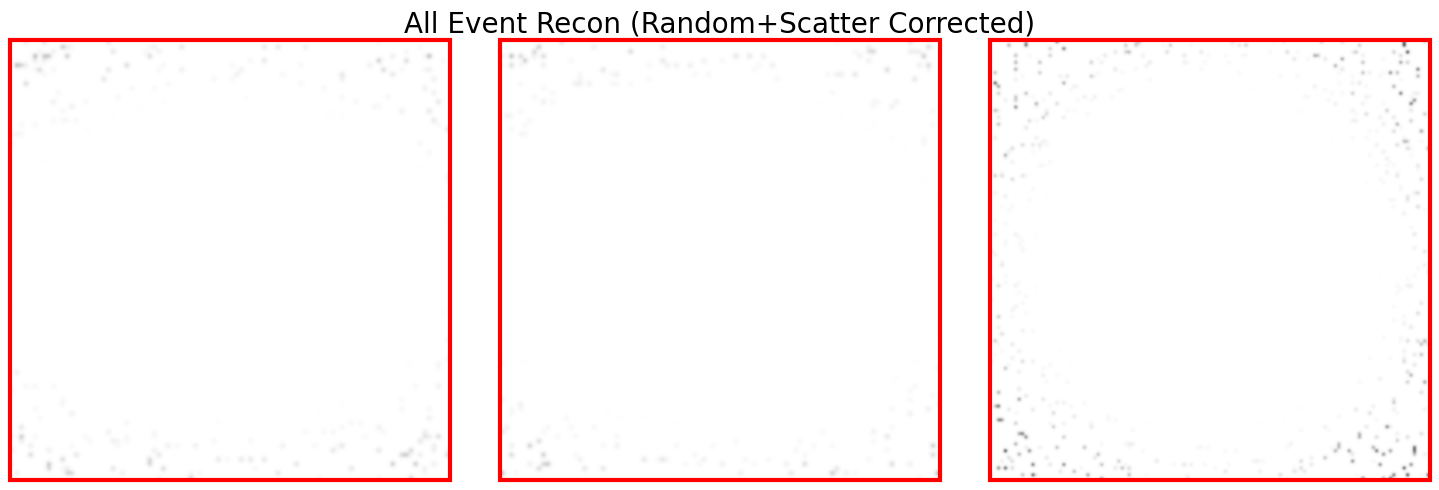

In [9]:
from matplotlib.patches import Rectangle

cmap = 'Greys'
fig, axarr = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'wspace': 0.0})

# Helper to add colored border
def add_border(ax, color='red', linewidth=3):
    rect = Rectangle(
        (0, 0), 1, 1, fill=False, transform=ax.transAxes,
        clip_on=False, linewidth=linewidth, edgecolor=color
    )
    ax.add_patch(rect)

# Calculate vmin and vmax from recon_lm_nontof
vmin = float(recon_lm_nontof.min().cpu())
vmax = float(recon_lm_nontof.max().cpu())

# Axial slice
axarr[0].imshow(recon_lm_nontof[48, 16:-16].cpu().T, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='gaussian', origin='lower')
axarr[0].axis('off')
add_border(axarr[0])

# Coronal slice
axarr[1].imshow(recon_lm_nontof[16:-16, 64].cpu().T, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='gaussian', origin='lower')
axarr[1].set_title('All Event Recon (Random+Scatter Corrected)', fontsize=20)
axarr[1].axis('off')
add_border(axarr[1])

# Sagittal slice
axarr[2].imshow(recon_lm_nontof[:, :, 48].cpu().T, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='gaussian', origin='lower')
axarr[2].axis('off')
add_border(axarr[2])

fig.tight_layout()
plt.show()


In [10]:
print(recon_lm_nontof.shape)
print(recon_lm_nontof.mean())
print(recon_lm_nontof.min())
print(recon_lm_nontof.max())

torch.Size([128, 128, 96])
tensor(7.0065e-45)
tensor(0.)
tensor(5.8294e-43)


In [11]:
# # Visualisation Functions
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider


def visualize_voxel_tensor_3d(voxel_tensor, initial_min_threshold=None, initial_max_threshold=None, 
                               voxel_size_mm=1.0, world_origin=None, min_threshold=None, max_threshold=None):
    """
    Interactive 3D visualization of voxel tensor with dual threshold sliders.

    Args:
        voxel_tensor: (nx, ny, nz) numpy array with voxel counts
        initial_min_threshold: Initial minimum threshold value for the slider (default: min_val)
        initial_max_threshold: Initial maximum threshold value for the slider (default: max_val)
        voxel_size_mm: Size of each voxel in mm (default: 1.0mm)
        world_origin: (x_min, y_min, z_min) world coordinates of voxel (0,0,0) (optional)
        min_threshold: Minimum threshold value for slider range (optional)
        max_threshold: Maximum threshold value for slider range (optional)
    """
    # Extract non-zero voxel coordinates and values
    coords = np.where(voxel_tensor > 0)
    x_coords, y_coords, z_coords = coords
    values = voxel_tensor[coords]

    # Convert voxel indices to world coordinates if world_origin provided
    if world_origin is not None:
        x_min, y_min, z_min = world_origin
        x_coords_world = x_coords * voxel_size_mm + x_min
        y_coords_world = y_coords * voxel_size_mm + y_min
        z_coords_world = z_coords * voxel_size_mm + z_min
        coord_suffix = " (mm)"
    else:
        x_coords_world = x_coords * voxel_size_mm
        y_coords_world = y_coords * voxel_size_mm
        z_coords_world = z_coords * voxel_size_mm
        coord_suffix = f" (×{voxel_size_mm}mm)"

    # Get value range for sliders
    min_val = float(np.min(values))
    max_val = float(np.max(values))

    # Use user-specified min/max threshold range if provided
    slider_min = min_threshold if min_threshold is not None else min_val
    slider_max = max_threshold if max_threshold is not None else max_val

    # Set initial thresholds with defaults
    if initial_min_threshold is None:
        initial_min_threshold = slider_min
    else:
        initial_min_threshold = max(slider_min, min(slider_max, float(initial_min_threshold)))
    
    if initial_max_threshold is None:
        initial_max_threshold = slider_max
    else:
        initial_max_threshold = max(slider_min, min(slider_max, float(initial_max_threshold)))

    # Ensure min <= max
    if initial_min_threshold > initial_max_threshold:
        initial_min_threshold, initial_max_threshold = initial_max_threshold, initial_min_threshold

    print(f"Voxel value range: {min_val} to {max_val}")
    print(f"Total non-zero voxels: {len(values)}")
    print(f"Initial thresholds: {initial_min_threshold} to {initial_max_threshold}")
    print(f"Slider range: {slider_min} to {slider_max}")
    print(f"Voxel resolution: {voxel_size_mm}mm")

    def update_plot(min_thresh, max_thresh):
        # Ensure min <= max
        if min_thresh > max_thresh:
            min_thresh, max_thresh = max_thresh, min_thresh

        # Filter voxels within threshold range
        mask = (values >= min_thresh) & (values <= max_thresh)
        if not np.any(mask):
            print(f"No voxels in threshold range [{min_thresh}, {max_thresh}]")
            return

        filtered_x = x_coords_world[mask]
        filtered_y = y_coords_world[mask]
        filtered_z = z_coords_world[mask]
        filtered_values = values[mask]

        # Create 3D scatter plot
        fig = go.Figure(data=go.Scatter3d(
            x=filtered_x,
            y=filtered_y,
            z=filtered_z,
            mode='markers',
            marker=dict(
                size=1,
                color=filtered_values,
                colorscale='Viridis',
                opacity=0.8,
                colorbar=dict(title="Voxel Count"),
                line=dict(width=0)
            ),
            text=[f'Count: {v}' for v in filtered_values],
            hovertemplate='<b>Voxel (%{x:.1f}, %{y:.1f}, %{z:.1f})</b><br>%{text}<extra></extra>'
        ))

        fig.update_layout(
            title=f'3D Voxel Visualization (Range: [{min_thresh:.6f}, {max_thresh:.6f}], Showing: {len(filtered_values)} voxels)',
            scene=dict(
                xaxis_title=f'X{coord_suffix}',
                yaxis_title=f'Y{coord_suffix}',
                zaxis_title=f'Z{coord_suffix}',
                camera=dict(
                    eye=dict(x=1.5, y=1.5, z=1.5)
                ),
                aspectmode='cube'
            ),
            width=800,
            height=600
        )

        fig.show()

    # Create interactive sliders with linked constraints
    min_threshold_slider = FloatSlider(
        value=initial_min_threshold,
        min=slider_min,
        max=slider_max,
        step=0.01,
        description='Min Threshold:',
        continuous_update=False,
        style={'description_width': 'initial'}
    )

    max_threshold_slider = FloatSlider(
        value=initial_max_threshold,
        min=slider_min,
        max=slider_max,
        step=0.01,
        description='Max Threshold:',
        continuous_update=False,
        style={'description_width': 'initial'}
    )

    # Link sliders to maintain min <= max constraint
    def on_min_change(change):
        if change['new'] > max_threshold_slider.value:
            max_threshold_slider.value = change['new']

    def on_max_change(change):
        if change['new'] < min_threshold_slider.value:
            min_threshold_slider.value = change['new']

    min_threshold_slider.observe(on_min_change, names='value')
    max_threshold_slider.observe(on_max_change, names='value')

    interact(update_plot, 
             min_thresh=min_threshold_slider, 
             max_thresh=max_threshold_slider)


from plotly.subplots import make_subplots
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact, IntSlider, FloatSlider

def plot_cross_sections_interactive(numpy_array, vmax=None, title="Orthogonal Cross Sections"):
    """
    Create an interactive 3D cross-section viewer for a 3D numpy array.
    
    Parameters:
    -----------
    numpy_array : np.ndarray
        3D numpy array to visualize (shape: nx, ny, nz)
    vmax : float, optional
        Maximum value for color scale. If None, uses array maximum
    title : str, optional
        Title for the plot
    """
    
    # Ensure input is numpy array
    if not isinstance(numpy_array, np.ndarray):
        raise ValueError("Input must be a numpy array")
    
    if numpy_array.ndim != 3:
        raise ValueError("Input must be a 3D array")
    
    nx, ny, nz = numpy_array.shape
    
    # Set default vmax if not provided
    if vmax is None:
        vmax = numpy_array.max()
    
    def plot_cross_sections_horizontal(x_idx=nx//2, y_idx=ny//2, z_idx=nz//2, 
                                     vmax_slider=vmax, cmap='Magma'):
        fig = make_subplots(rows=1, cols=3, subplot_titles=[
            f'XY plane @ z={z_idx}',
            f'XZ plane @ y={y_idx}',
            f'YZ plane @ x={x_idx}'
        ])

        # XY plane at z=z_idx
        fig.add_trace(go.Heatmap(
            z=numpy_array[:, :, z_idx].T,
            colorscale=cmap,
            zmax=vmax_slider,
            zmin=0,
            showscale=True,
            name=f'XY @ z={z_idx}'
        ), row=1, col=1)

        # XZ plane at y=y_idx
        fig.add_trace(go.Heatmap(
            z=numpy_array[:, y_idx, :].T,
            colorscale=cmap,
            zmax=vmax_slider,
            zmin=0,
            showscale=True,
            name=f'XZ @ y={y_idx}'
        ), row=1, col=2)

        # YZ plane at x=x_idx
        fig.add_trace(go.Heatmap(
            z=numpy_array[x_idx, :, :].T,
            colorscale=cmap,
            zmax=vmax_slider,
            zmin=0,
            showscale=True,
            name=f'YZ @ x={x_idx}'
        ), row=1, col=3)

        fig.update_layout(
            width=1200,
            height=400,
            title_text=title
        )
        fig.show()

    # Create interactive widget
    interact(
        plot_cross_sections_horizontal,
        x_idx=IntSlider(min=0, max=nx-1, step=1, value=nx//2, description='X index'),
        y_idx=IntSlider(min=0, max=ny-1, step=1, value=ny//2, description='Y index'),
        z_idx=IntSlider(min=0, max=nz-1, step=1, value=nz//2, description='Z index'),
        vmax_slider=FloatSlider(min=0, max=numpy_array.max(), step=0.01, value=vmax, description='vmax'),
        cmap=['Magma','Greys', 'Viridis', 'Cividis', 'Plasma']
    )

# numpy_array = recon_lm_nontof.numpy() # For tensors on CPU
numpy_array = recon_lm_nontof.cpu().numpy() # For tensors on GPU, first move to CPU

# visualize_voxel_tensor_3d(numpy_array)
plot_cross_sections_interactive(numpy_array)

interactive(children=(IntSlider(value=64, description='X index', max=127), IntSlider(value=64, description='Y …